# Importing Libraries

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the dataset

In [25]:
df = pd.read_csv(r"personalized_education_simulated_dataset.csv")

# Encoding categorical features to numerical values

In [26]:
label_encoders = {}
for column in ['Gender', 'Learning Style', 'Attention Span', 'Parental Involvement', 'Technology Use', 'Intervention', 'Outcome']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Features and target variable

In [27]:
X = df.drop(['Student ID', 'Outcome'], axis=1).values
y = df['Outcome'].values

# Scaling features for better neural network performance

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# Convert to PyTorch tensors and reshape for LSTM

In [30]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Reshape to (samples, 1, features)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# # Define the custom LSTM model

In [31]:
class CustomLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CustomLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass through fully connected layer
        out = self.fc(out[:, -1, :])  # Output from last time step
        return torch.sigmoid(out)

# Parameter Initialisation and Model Instantiation

In [32]:
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # Hidden layer size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Binary classification (0 or 1)

# Instantiate the model, define the loss function and optimizer
model = CustomLSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model

In [33]:
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    losses=[]
    # Zero the gradient
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # Track loss for visualization
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/100], Loss: 0.6526
Epoch [10/100], Loss: 0.6400
Epoch [15/100], Loss: 0.6267
Epoch [20/100], Loss: 0.6119
Epoch [25/100], Loss: 0.5947
Epoch [30/100], Loss: 0.5741
Epoch [35/100], Loss: 0.5490
Epoch [40/100], Loss: 0.5183
Epoch [45/100], Loss: 0.4813
Epoch [50/100], Loss: 0.4379
Epoch [55/100], Loss: 0.3893
Epoch [60/100], Loss: 0.3378
Epoch [65/100], Loss: 0.2869
Epoch [70/100], Loss: 0.2401
Epoch [75/100], Loss: 0.2003
Epoch [80/100], Loss: 0.1689
Epoch [85/100], Loss: 0.1454
Epoch [90/100], Loss: 0.1277
Epoch [95/100], Loss: 0.1137
Epoch [100/100], Loss: 0.1015


# Evaluate the model on test data

In [34]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred.squeeze() > 0.5).float()  # Convert to binary class (0 or 1)
    accuracy = accuracy_score(y_test, y_pred_class)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")




Test Accuracy: 34.00%


# Predicted Output

In [35]:
new_student = np.array([[15, 1, 2, 88, 85, 90, 1, 2, 8, 0, 1]])
new_student_scaled = scaler.transform(new_student)
new_student_tensor = torch.tensor(new_student_scaled, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    predicted_outcome = model(new_student_tensor)
    predicted_class = (predicted_outcome.squeeze() > 0.5).float()
    print("Predicted Outcome for new student:", label_encoders['Outcome'].inverse_transform([int(predicted_class.item())]))

Predicted Outcome for new student: ['Improved']


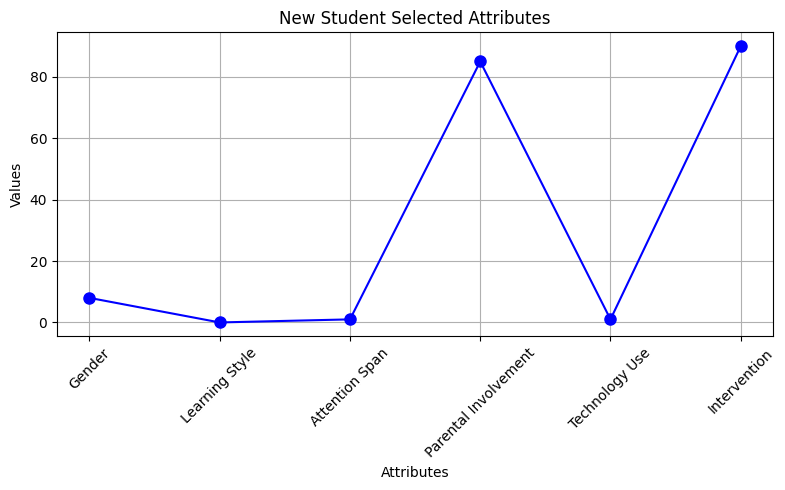

C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


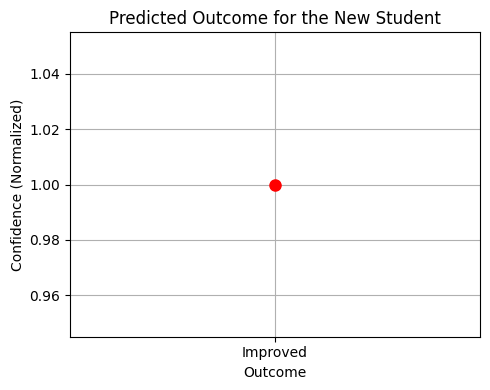

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of selected attributes
selected_attributes = ['Gender', 'Learning Style', 'Attention Span', 'Parental Involvement', 
                       'Technology Use', 'Intervention']

# Get the corresponding values for the new student (only the selected attributes)
new_student_data = [new_student[0][8], new_student[0][9], new_student[0][1], 
                    new_student[0][4], new_student[0][6], new_student[0][5]]  # Selected indices

# 1. Visualizing Selected Attributes of the New Student as a Line Graph
plt.figure(figsize=(8, 5))
plt.plot(selected_attributes, new_student_data, marker='o', linestyle='-', color='b', markersize=8)
plt.title("New Student Selected Attributes")
plt.xlabel("Attributes")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Visualizing the Model's Prediction Outcome as a Line Graph
# Convert predicted_outcome tensor to NumPy, then make it binary (0 or 1)
predicted_binary_outcome = np.round(predicted_outcome.detach().numpy()).astype(int)  # Convert probability to 0 or 1

# Get the original labels
outcome_labels = list(label_encoders['Outcome'].classes_)
predicted_label = label_encoders['Outcome'].inverse_transform(predicted_binary_outcome)[0]

# Create a line plot for the outcome
plt.figure(figsize=(5, 4))
plt.plot([predicted_label], [1], marker='o', color='r', markersize=8)  # Show only the predicted outcome
plt.title("Predicted Outcome for the New Student")
plt.xlabel("Outcome")
plt.ylabel("Confidence (Normalized)")
plt.xticks([predicted_label])  # Show only the predicted label on x-axis
plt.grid(True)
plt.tight_layout()
plt.show()
